In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from PIL import Image

import tensorflow as tf
# from tensorflow.keras.applications import vit   
# from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, applications, callbacks
from tensorflow.keras.utils import to_categorical

In [43]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs detected. Running on CPU.")

GPUs detected:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [44]:
csv_file = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
image_folder = '/kaggle/input/isic-2024-challenge/train-image'

In [45]:
df = pd.read_csv(csv_file)
# df['target'] = df['target'].astype(int)

/tmp/ipykernel_30/702341164.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


In [46]:
target_0 = df[df['target'] == 0]
target_1 = df[df['target'] == 1]


target_0_downsampled = target_0.sample(n=1000, random_state=42)


df_downsampled = pd.concat([target_0_downsampled, target_1], axis=0).reset_index(drop=True)

df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset size: {len(df)}")
print(f"Downsampled dataset size: {len(df_downsampled)}")
print(df_downsampled['target'].value_counts())


Original dataset size: 401059
Downsampled dataset size: 1393
target
0    1000
1     393
Name: count, dtype: int64


In [47]:
df = df_downsampled

In [48]:
train_idx, temp_idx = train_test_split(df.index, test_size=0.2, stratify=df['target'], random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=df.loc[temp_idx, 'target'], random_state=42)


In [49]:
train_df = df.loc[train_idx].copy()
val_df = df.loc[val_idx].copy()
test_df = df.loc[test_idx].copy()

In [50]:
train_image_path = image_folder+"/image/" + train_df['isic_id'] + '.jpg'
val_image_path = image_folder+"/image/" + val_df['isic_id'] + '.jpg'
test_image_path = image_folder +"/image/"+ test_df['isic_id'] + '.jpg'

In [51]:
train_df['image_path'] = train_image_path
val_df['image_path'] = val_image_path
test_df['image_path'] = test_image_path

In [52]:
train_df.target.iloc[0:1]

380    0
Name: target, dtype: int64

(-0.5, 116.5, 116.5, -0.5)

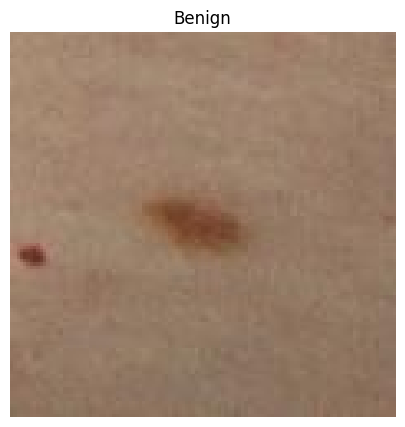

In [53]:
img = Image.open(train_df.image_path.iloc[20])

plt.figure(figsize=(10, 5))
plt.title("Benign" if train_df.target.iloc[20]==0 else "Malignant")
plt.imshow(img)  
plt.axis('off') 

In [54]:
def create_datagen(dataframe, image_folder, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_folder,
        x_col='image_path',
        y_col='target',
        target_size=(224, 224),
        class_mode='binary',
        batch_size=32,
        shuffle=True
    )
    return generator

In [55]:
def create_densenet_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = applications.DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = True  # False Freeze the base model, will have 0 trainable parameters
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    # model.summary()
    return model

In [56]:
train_df['target'] = train_df['target'].astype(str)
val_df['target'] = val_df['target'].astype(str)
test_df['target'] = test_df['target'].astype(str)

In [57]:
train_gen = create_datagen(train_df, image_folder, augment=True)
val_gen = create_datagen(val_df, image_folder)
test_gen = create_datagen(test_df, image_folder)

# will take time

Found 1114 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.


In [58]:
model = create_densenet_model(num_classes=2)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [60]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.1, patience=3)

In [61]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100
    # callbacks=[reduce_lr]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6706 - loss: 0.8105 - val_accuracy: 0.7194 - val_loss: 0.5929
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.7454 - loss: 0.5685 - val_accuracy: 0.7194 - val_loss: 0.6241
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.7897 - loss: 0.5273 - val_accuracy: 0.7194 - val_loss: 0.6711
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - accuracy: 0.7904 - loss: 0.4749 - val_accuracy: 0.7194 - val_loss: 0.6970
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step - accuracy: 0.7988 - loss: 0.4757 - val_accuracy: 0.7194 - val_loss: 0.8541
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - accuracy: 0.7785 - loss: 0.4904 - val_accuracy: 0.7194 - val_loss: 0.9795
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 319ms/step - accuracy: 0.8011 - loss: 0.4984 - val_accuracy: 0.4532 - val_loss: 1.5685
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.7811 - loss: 0.4864 - val_accuracy: 

In [35]:
# history.history['accuracy']

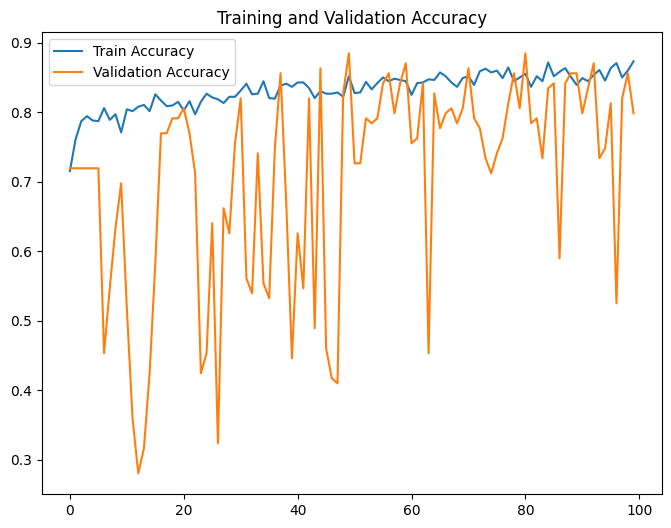

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

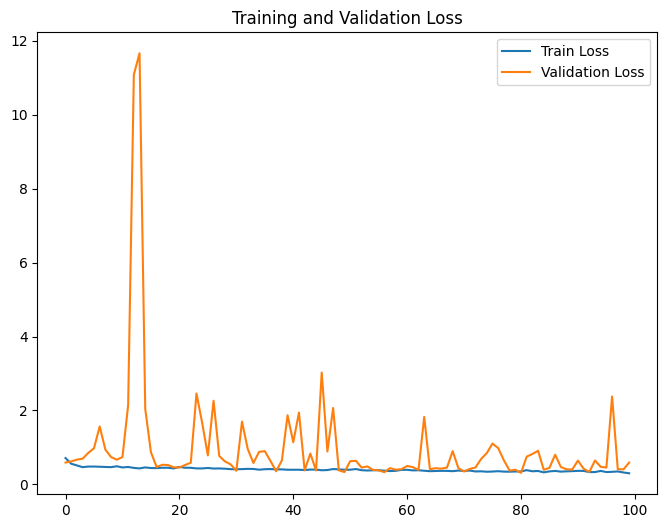

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [64]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8231 - loss: 0.6268  
Test Loss: 0.6807, Test Accuracy: 0.8000


In [66]:
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Confusion Matrix

<Figure size 600x600 with 0 Axes>

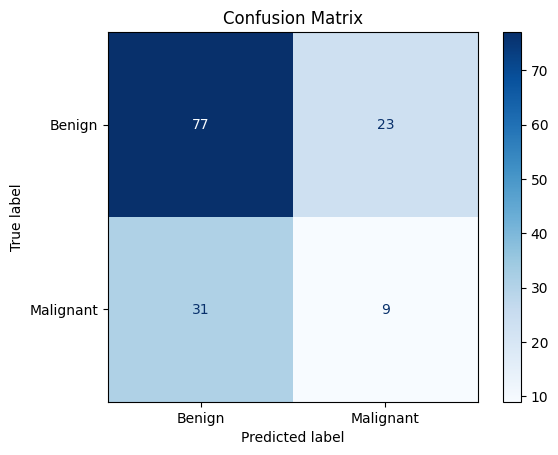

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


ROC curve

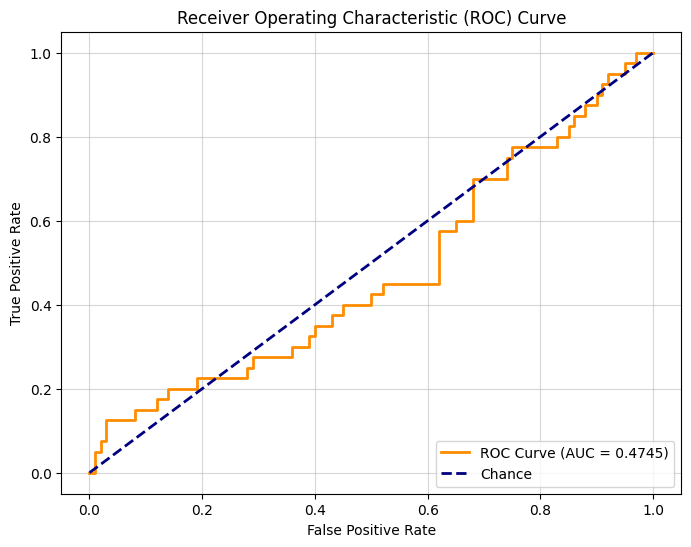

In [68]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

Heatmap

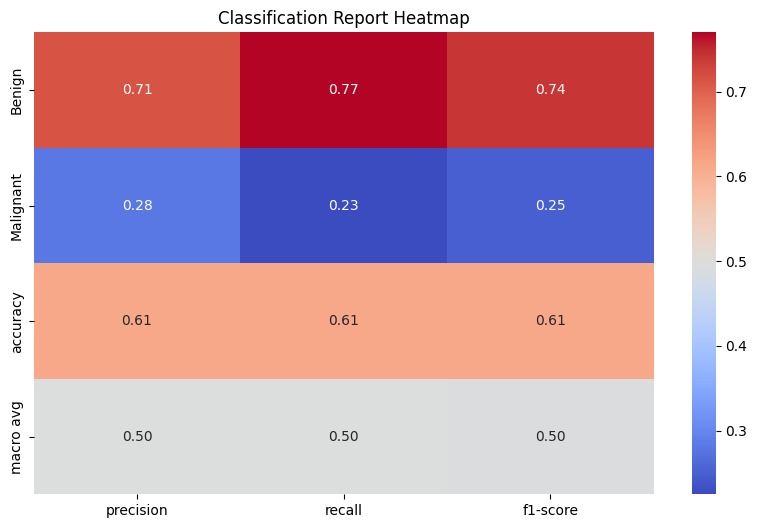

In [69]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report


report = classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()


In [70]:
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

try:
    auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    print(f"AUC: {auc:.4f}")
except ValueError:
    print("AUC calculation failed due to lack of positive/negative samples.")

              precision    recall  f1-score   support

      Benign       0.71      0.77      0.74       100
   Malignant       0.28      0.23      0.25        40

    accuracy                           0.61       140
   macro avg       0.50      0.50      0.50       140
weighted avg       0.59      0.61      0.60       140

AUC: 0.4745
